# Проект: Промышленность

*Описание задачи*

<h2>Тема «Оптимизация производственных расходов» <a class="tocSkip"> </h2>

Чтобы оптимизировать производственные расходы,
металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.
Предстоит построить модель, которая предскажет температуру стали.
Задача регрессионная: нужно предсказать количественный показатель.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.
Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.
Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.
Затем его перемешивают и снова проводят измерения.
Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки.
Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

**Целевой признак**

Конечная «Температура» файла data_temp_new.csv.

## Загрузка данных

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    r2_score
)
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [105]:
# установим phik 
import sys

!"{sys.executable}" -m pip install phik -q
import phik
#from phik import resources, report
#from phik.binning import bin_data
#from phik.report import plot_correlation_matrix

In [106]:
# установим также и shap
!pip install shap
import shap

In [107]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2]) # чтобы сразу тип данных для дат был корректным
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])


RANDOM_STATE = 170624

In [108]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [109]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [110]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [111]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [112]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [113]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [114]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


    Вывод: все датафреймы требуют изменения названий столбцов, практически во всех - есть пропуски. Посмотрим на каждый датафрейм более пристально. 

## Исследовательский анализ и предобработка данных

### Исследовательский анализ данных и предобработка

#### Данные об электродах (Датафрейм data_arc)

In [115]:
data_arc.head(15) # смотрим первый датафрейм с информацией об электродах

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [116]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Необходимо:
* поменять названия столбцов (привести к нормальному формату), 
* удалить строку с отрицательным значением реактивной мощности (в соответствии с пожеланиями Заказчика)
* агрегировать данные по партиям, т.к. партии, очевидно, нагреваются разное количество раз (при этом можно добавить признак количества итераций, вдруг поможет)

Также можно сразу добавить признаки:
* полной мощности, которая складывается из двух имеющихся мощностей по формуле:
Полная мощность = √ (Активная мощность^2 + Реактивная мощность^2) 
* длительности нагрева

In [117]:
# новые названия столбцов
data_arc_columns = {
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_finish',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power',
}
data_arc = data_arc.rename(columns=data_arc_columns)

In [118]:
# удаляем отрицательное значение реактивной мощности
data_arc = data_arc.query('reactive_power > 0')

In [119]:
# считаем количество итераций нагрева, позже добавим эти данные к агрегированным по суммам
iterations = data_arc['key'].value_counts().reset_index(name='iterations').rename(columns={'index': 'key'})

In [120]:
iterations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   key         3214 non-null   int64
 1   iterations  3214 non-null   int64
dtypes: int64(2)
memory usage: 50.3 KB


In [121]:
# добавляем столбец полной мощности
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

In [122]:
# добавляем столбец длительности нагрева
data_arc['arc_heating_time'] = data_arc['arc_heating_finish'] - data_arc['arc_heating_start']
data_arc['arc_heating_time'] = data_arc['arc_heating_time'].dt.seconds


In [123]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14875 non-null  int64         
 1   arc_heating_start   14875 non-null  datetime64[ns]
 2   arc_heating_finish  14875 non-null  datetime64[ns]
 3   active_power        14875 non-null  float64       
 4   reactive_power      14875 non-null  float64       
 5   full_power          14875 non-null  float64       
 6   arc_heating_time    14875 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 929.7 KB


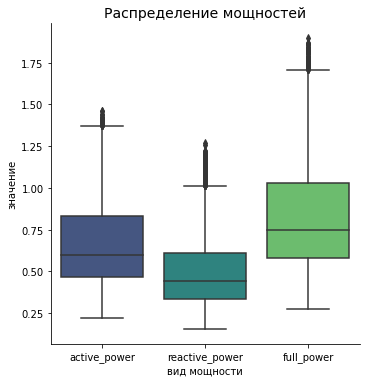

In [124]:
#data_arc.boxplot(column='active_power')
#data_arc.boxplot(column='reactive_power')
#data_arc.boxplot(column='full_power')
sns.catplot(kind="box", data=data_arc[['active_power', 'reactive_power', 'full_power']], palette='viridis', height=5)
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('вид мощности')
plt.ylabel('значение')
plt.show()

Очевидно, в данных есть выбросы/аномалии выше верхних усов боксплотов.

<AxesSubplot:>

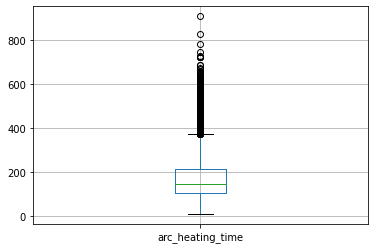

In [125]:
# также посмотрим на боксплот длительности нагрева 
data_arc.boxplot(column='arc_heating_time')

Здесь тоже есть аномальные значения по верхней границе 

In [126]:
data_arc.describe()

,key,active_power,reactive_power,full_power,arc_heating_time
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115,0.823385,171.675160
std,934.593897,0.258894,0.197612,0.323470,98.188759
min,1.000000,0.223120,0.153777,0.275718,11.000000
25%,806.000000,0.467115,0.337190,0.578839,107.000000
50%,1617.000000,0.599578,0.441665,0.746554,147.000000
75%,2429.000000,0.830135,0.608223,1.030402,214.000000
max,3241.000000,1.463773,1.270284,1.898158,907.000000


In [127]:
final_data_arc = data_arc.groupby(by = 'key').sum()
final_data_arc = final_data_arc.merge(iterations, on='key')
final_data_arc.head(5)

,key,active_power,reactive_power,full_power,arc_heating_time,iterations
0,1,3.036730,2.142821,3.718736,1098,5
1,2,2.139408,1.453357,2.588349,811,4
2,3,4.063641,2.937457,5.019223,655,5
3,4,2.706489,2.056992,3.400038,741,4
4,5,2.252950,1.687991,2.816980,869,4


In [128]:
final_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   active_power      3214 non-null   float64
 2   reactive_power    3214 non-null   float64
 3   full_power        3214 non-null   float64
 4   arc_heating_time  3214 non-null   int64  
 5   iterations        3214 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 175.8 KB


пропусков нет

#### Данные о подаче сыпучих материалов (объём, Датафрейм data_bulk)

In [129]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [130]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


БОльшая часть сыпучих материалов добавляется всего в нескольких партиях:

In [131]:
# 
def missing_values(df):
    percent_missing = round(df.isnull().sum() * 100 / len(df))
    percent_missing = percent_missing.astype(int)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}).sort_values(by='percent_missing')
    return missing_value_df

In [132]:
missing_values(data_bulk)

,column_name,percent_missing
key,key,0
Bulk 14,Bulk 14,10
Bulk 12,Bulk 12,22
Bulk 15,Bulk 15,28
Bulk 3,Bulk 3,59
Bulk 4,Bulk 4,68
Bulk 6,Bulk 6,82
Bulk 1,Bulk 1,92
Bulk 10,Bulk 10,94
Bulk 11,Bulk 11,94


Таким образом, видим, что меньше 80% пропущенных значений есть только в добавках под номерами 14, 12, 15, 3, и 4. Все остальные нужно удалить по условию задачи.

In [133]:
# оставляем только нужные столбцы
final_data_bulk = data_bulk[['key', 'Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15']]

In [134]:
# заполняем пропуски нулями
final_data_bulk = final_data_bulk.fillna(0) 

In [135]:
# приводим названия столбцов к нормальному виду
final_data_bulk_columns = {
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 12': 'bulk_12',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15',
}
final_data_bulk = final_data_bulk.rename(columns=final_data_bulk_columns)

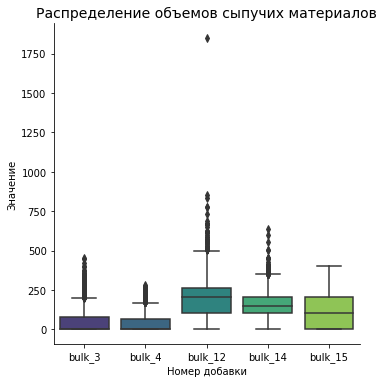

In [136]:
sns.catplot(kind="box", data=final_data_bulk[['bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']], palette='viridis', height=5)
plt.title('Распределение объемов сыпучих материалов', fontsize=14)
plt.xlabel('Номер добавки')
plt.ylabel('Значение')
plt.show()

Во всех итерациях добавок, кроме последней, присутствуют выбросы/аномалии. Это логично, т.к. благодаря последней добавке достигается оптимальная температура и состав сплава.

In [137]:
final_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_3   3129 non-null   float64
 2   bulk_4   3129 non-null   float64
 3   bulk_12  3129 non-null   float64
 4   bulk_14  3129 non-null   float64
 5   bulk_15  3129 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 146.8 KB


In [138]:
final_data_bulk.describe()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,47.240332,33.830617,203.948226,152.706616,115.319271
std,933.337642,74.239954,56.034505,151.419639,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,105.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,206.000000,148.000000,106.000000
75%,2431.000000,80.000000,68.000000,263.000000,202.000000,204.000000
max,3241.000000,454.000000,281.000000,1849.000000,636.000000,405.000000


In [139]:
final_data_bulk.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


можно еще все значения привести к целому типу данных:

In [140]:
final_data_bulk = final_data_bulk.astype('int')

In [141]:
final_data_bulk.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0,43,206,150,154
1,2,0,73,206,149,154
2,3,0,34,205,152,153
3,4,0,81,207,153,154
4,5,0,78,203,151,152


#### Данные о времени подачи сыпучих материалов (объём, Датафрейм data_bulk_time)

In [142]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [143]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Это вспомогательная таблица, данные бьются с предыдущей (только здесь отображается время подачи материалов).

#### Данные о подаче проволочных материалов (объём, Датафрейм data_wire)

In [144]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [145]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь очень много пропусков, бОльшая часть столбцов подлежит удалению, т.к. содержит более 80% пропусков:

In [146]:
missing_values(data_wire)

,column_name,percent_missing
key,key,0
Wire 1,Wire 1,1
Wire 2,Wire 2,65
Wire 3,Wire 3,98
Wire 6,Wire 6,98
Wire 8,Wire 8,99
Wire 9,Wire 9,99
Wire 4,Wire 4,100
Wire 5,Wire 5,100
Wire 7,Wire 7,100


Оставляем только 2 первых итерации добавок:

In [147]:
final_data_wire = data_wire[['key', 'Wire 1', 'Wire 2']]

Заполняем пропуски нулями, меняем названия столбцов:

In [148]:
final_data_wire = final_data_wire.fillna(0) 

final_data_wire_columns = {
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2'
}
final_data_wire = final_data_wire.rename(columns=final_data_wire_columns)

In [149]:
final_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


In [150]:
final_data_wire.describe()

,key,wire_1,wire_2
count,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733
std,932.996726,42.841120,33.517734
min,1.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000
50%,1619.000000,100.114563,0.000000
75%,2434.000000,125.798405,23.162880
max,3241.000000,330.314424,282.780152


In [151]:
final_data_wire.head()

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


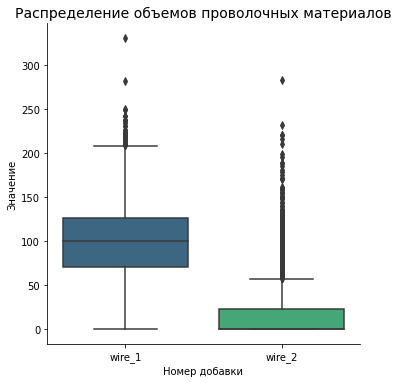

In [152]:
sns.catplot(kind="box", data=final_data_wire[['wire_1', 'wire_2']], palette='viridis', height=5)
plt.title('Распределение объемов проволочных материалов', fontsize=14)
plt.xlabel('Номер добавки')
plt.ylabel('Значение')
plt.show()

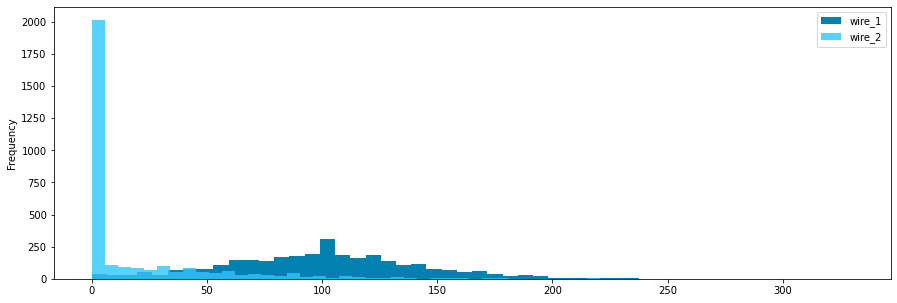

In [153]:
plt.figure(figsize=(15, 5))
final_data_wire['wire_1'].plot(kind='hist', bins=50, legend=True, color='#0081AF')
final_data_wire['wire_2'].plot(kind='hist', bins=50, legend=True, color='#2DC7FF', alpha=0.8)
plt.show()

Распределение значений первой итерации добавок похоже на нормальное, второе содержит очень много нулевых значений.

#### Данные о времени подачи проволочных материалов (объём, Датафрейм data_wire_time)

In [154]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Это так же, как и data_bulk_time, вспомогательная таблица, данные бьются с предыдущей (только здесь отображается время подачи материалов).

#### Данные о продувке сплава газом (Датафрейм data_gas)

In [156]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [157]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [158]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [159]:
# приведем названия столбцов к нормальеому виду

data_gas_columns = {
    'Газ 1': 'gas_1',
}
data_gas = data_gas.rename(columns=data_gas_columns)

Text(0, 0.5, 'Количество итераций (добавок)')

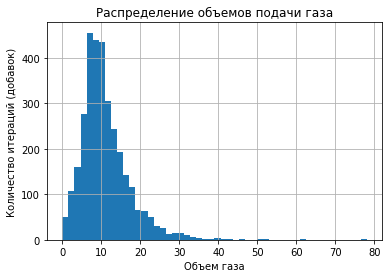

In [160]:
data_gas['gas_1'].hist(bins = 50)
plt.title('Распределение объемов подачи газа')
plt.xlabel('Объем газа')
plt.ylabel('Количество итераций (добавок)')

Распределение похоже на нормальное с некоторым количеством аномалий (значения до 77). Проверим на нормальность двумя способами:

In [161]:
# способом Шапиро
stat, p = shapiro(data_gas['gas_1'])
display('stat=%.3f, p=%.3f\n' % (stat, p))
#print(stat, p)
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

'stat=0.887, p=0.000\n'

Probably not Gaussian


In [162]:
stat, p = normaltest(data_gas['gas_1'])
display('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

'stat=1435.015, p=0.000\n'

Probably not Gaussian


Распределение все же не нормальное.

#### Данные об измерении температуры (Датафрейм data_temp)

In [163]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [164]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [165]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [166]:
# приводим названия столбцов к нормальному виду:
data_temp_columns = {
    'Время замера': 'timestamp',
    'Температура': 'temperature',
}
data_temp = data_temp.rename(columns=data_temp_columns)

In [167]:
na = data_temp.isna().sum()[2]/len(data_temp) #берем третий столбец с температурой
print(f'Количество пропусков, столбец "temperature":, \n{na:.0%}')

Количество пропусков, столбец "temperature":, 
19%


In [168]:
# пропусков много, это целевой признак - удаляем их
data_temp = data_temp.dropna().reset_index(drop=True)
data_temp = data_temp.sort_values(by='timestamp')

In [169]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14665 non-null  int64         
 1   timestamp    14665 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


In [170]:
# учитывая, что данные пло температуре - целые значения, изменим тип данных:
data_temp['temperature'] = data_temp['temperature'].astype('int')

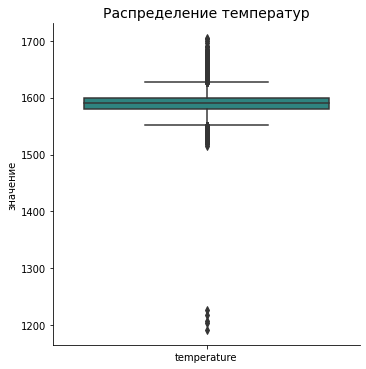

In [171]:
# посмотрим на боксплот
sns.catplot(kind="box", data=data_temp[['temperature']], palette='viridis', height=5)
plt.title('Распределение температур', fontsize=14)
plt.ylabel('значение')
plt.show()

Необходимо удалить строки со значениями ниже 1500 градусов (т.к. это твердое состояние)


In [172]:
data_temp = data_temp.query('temperature >= 1500')

In [173]:
data_temp.head()

,key,timestamp,temperature
0,1,2019-05-03 11:02:04,1571
1,1,2019-05-03 11:07:18,1604
2,1,2019-05-03 11:11:34,1618
3,1,2019-05-03 11:18:04,1601
4,1,2019-05-03 11:25:59,1606


Теперь нужно выявить есть ли ключи с одним замером температуры и если есть - удалить их, т.к. у нас не будет показателя верного значения целевого признака.

In [174]:
# считаем количество итераций измерений
temp_iterations = data_temp['key'].value_counts().reset_index(name='temp_iterations').rename\
(columns={'index': 'key'}).sort_values(by=['temp_iterations', 'key'], ascending=False)
temp_iterations.tail(10)

,key,temp_iterations
3013,2507,1
2819,2506,1
2753,2505,1
2685,2504,1
3021,2503,1
2689,2502,1
2865,2501,1
2829,2500,1
2629,279,1
2821,195,1


Получается, что измерения с ключами 2500 и выше, а также ключи 279 и 195 - с одним измерением - их нужно удалить.

In [175]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14660 non-null  int64         
 1   timestamp    14660 non-null  datetime64[ns]
 2   temperature  14660 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 458.1 KB


In [176]:
data_temp = data_temp.query('key < 2500')

In [177]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13922 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13922 non-null  int64         
 1   timestamp    13922 non-null  datetime64[ns]
 2   temperature  13922 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 435.1 KB


In [178]:
data_temp = data_temp[((data_temp['key'] != 279) & (data_temp['key'] != 195))] 

# можно было удалить и вот так:
#count = data_temp.groupby(by = 'key', as_index = False).count()
#one = count[count['timestamp'] == 1]['key'].tolist()
#data_temp = data_temp.query('key not in @one')

In [179]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13920 non-null  int64         
 1   timestamp    13920 non-null  datetime64[ns]
 2   temperature  13920 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 435.0 KB


Проверим еще раз на наличие ключей с одним замером:

In [180]:
temp_iterations = data_temp['key'].value_counts().reset_index(name='temp_iterations').rename\
(columns={'index': 'key'}).sort_values(by=['temp_iterations', 'key'], ascending=False)
temp_iterations.tail(10)

,key,temp_iterations
2446,614,2
2463,556,2
2460,530,2
2442,343,2
2445,269,2
2454,248,2
2450,247,2
2453,246,2
2465,112,2
2473,49,2


Добавим дополнительные признаки: 
* разницу во времени между первым и последним замером температуры, 
* разницу в температурах между первым и последним замером температуры

In [181]:
final_data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
final_data_temp.columns = ['key', 'first_temp_time', 'last_temp_time', 'first_temp', 'last_temp']
final_data_temp['time_temp_diff'] = final_data_temp['last_temp_time'] - final_data_temp['first_temp_time']
final_data_temp['time_temp_diff'] = final_data_temp['time_temp_diff'].dt.seconds
final_data_temp['temp_diff'] = final_data_temp['last_temp'] - final_data_temp['first_temp']
final_data_temp.head()

,key,first_temp_time,last_temp_time,first_temp,last_temp,time_temp_diff,temp_diff
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571,1613,1714,42
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581,1602,1265,21
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596,1599,1753,3
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601,1625,1220,24
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576,1602,1536,26


**Вывод по исследовательскому анализу:**

* Названия столбцов приведены к стандартному виду.
* Пропуски и выбросы где можно было, обработаны.
* Удалены признаки, по которым было совсем незначительное количество данных по партиям.
* Удалены ключи с одним измерением в целевом признаке.
* Добавлены дополнительные признаки там, где это показалось уместным.
* Финальные таблицы подготовлены для объединения в общую таблицу для обучения моделей.

## Объединение данных

Исходя из условия задачи, **объединяем 5 таблиц** (все, кроме вспомогательных таблиц по времени подачи сыпучих и проволочных материалов).

In [182]:
data = final_data_arc.merge(final_data_bulk, on='key', how='inner')
data = data.merge(final_data_wire, on='key', how='inner')
data = data.merge(data_gas, on='key', how='inner')
data = data.merge(final_data_temp, on='key', how='inner')


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2329 non-null   int64         
 1   active_power      2329 non-null   float64       
 2   reactive_power    2329 non-null   float64       
 3   full_power        2329 non-null   float64       
 4   arc_heating_time  2329 non-null   int64         
 5   iterations        2329 non-null   int64         
 6   bulk_3            2329 non-null   int64         
 7   bulk_4            2329 non-null   int64         
 8   bulk_12           2329 non-null   int64         
 9   bulk_14           2329 non-null   int64         
 10  bulk_15           2329 non-null   int64         
 11  wire_1            2329 non-null   float64       
 12  wire_2            2329 non-null   float64       
 13  gas_1             2329 non-null   float64       
 14  first_temp_time   2329 n

In [184]:
data.head()

,key,active_power,reactive_power,full_power,arc_heating_time,iterations,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas_1,first_temp_time,last_temp_time,first_temp,last_temp,time_temp_diff,temp_diff
0,1,3.036730,2.142821,3.718736,1098,5,0,43,206,150,154,60.059998,0.00000,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571,1613,1714,42
1,2,2.139408,1.453357,2.588349,811,4,0,73,206,149,154,96.052315,0.00000,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581,1602,1265,21
2,3,4.063641,2.937457,5.019223,655,5,0,34,205,152,153,91.160157,0.00000,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596,1599,1753,3
3,4,2.706489,2.056992,3.400038,741,4,0,81,207,153,154,89.063515,0.00000,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601,1625,1220,24
4,5,2.252950,1.687991,2.816980,869,4,0,78,203,151,152,89.238236,9.11456,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576,1602,1536,26


## Исследовательский анализ и предобработка данных объединённого датафрейма

### Исследовательский анализ и предобработка

In [185]:
data.describe()

,key,active_power,reactive_power,full_power,arc_heating_time,iterations,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas_1,first_temp,last_temp,time_temp_diff,temp_diff
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,3.125033,2.300522,3.884654,807.600687,4.695148,47.348218,37.303564,208.415629,153.853585,119.952769,102.443601,17.609859,11.375600,1587.386003,1593.365393,2321.810219,5.979390
std,714.762400,1.221007,0.903968,1.518157,340.897332,1.606948,75.310430,58.643238,157.062272,81.404354,84.640443,43.539993,33.624771,6.392041,23.619841,11.200915,1385.191527,22.889311
min,1.000000,0.267676,0.196228,0.331897,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,270.000000,-98.000000
25%,630.000000,2.293900,1.669572,2.843058,581.000000,4.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000,7.282948,1571.000000,1587.000000,1579.000000,-9.000000
50%,1255.000000,3.035365,2.225398,3.767499,778.000000,5.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000,10.100950,1587.000000,1593.000000,2045.000000,7.000000
75%,1868.000000,3.834300,2.829159,4.769421,993.000000,6.000000,80.000000,77.000000,282.000000,204.000000,204.000000,128.091599,23.102560,14.216688,1603.000000,1598.000000,2791.000000,22.000000
max,2499.000000,12.375636,8.949049,15.288271,4189.000000,16.000000,454.000000,281.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,77.995040,1660.000000,1653.000000,23674.000000,83.000000


**Удалим ненужные столбцы** `key`, `first_temp_time`, `last_temp_time`

In [186]:
columns_to_drop = ['key', 'first_temp_time', 'last_temp_time']
data = data.drop(columns=columns_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_power      2329 non-null   float64
 1   reactive_power    2329 non-null   float64
 2   full_power        2329 non-null   float64
 3   arc_heating_time  2329 non-null   int64  
 4   iterations        2329 non-null   int64  
 5   bulk_3            2329 non-null   int64  
 6   bulk_4            2329 non-null   int64  
 7   bulk_12           2329 non-null   int64  
 8   bulk_14           2329 non-null   int64  
 9   bulk_15           2329 non-null   int64  
 10  wire_1            2329 non-null   float64
 11  wire_2            2329 non-null   float64
 12  gas_1             2329 non-null   float64
 13  first_temp        2329 non-null   int64  
 14  last_temp         2329 non-null   int64  
 15  time_temp_diff    2329 non-null   int64  
 16  temp_diff         2329 non-null   int64  



    Добавим графики распределения и боксплоты для всех признаков: 

In [187]:
def sns_draw(data, column, bins=30):
        column = str(column)
        fig = plt.figure(figsize=(15, 6), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_right = fig.add_subplot(grid[:-1, -1])  
        sns.histplot(data[column], ax=ax_main)
        sns.boxplot(data[column], ax=ax_right)
        #ax_right.grid(axis='y')
        ax_main.set(title='Распределение признака '+ column)
        ax_main.axvline(np.mean(data[column]),color='r', linestyle='--', label='Среднее')
        ax_main.axvline(np.median(data[column]),color='g', linestyle='-', label='Медиана')
        ax_main.legend()
        fig.show()

active_power
reactive_power


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


full_power


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


arc_heating_time


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


iterations


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


bulk_3
bulk_4


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


bulk_12


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


bulk_14
bulk_15


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


wire_1
wire_2


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


gas_1


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


first_temp
last_temp


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


time_temp_diff


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


temp_diff


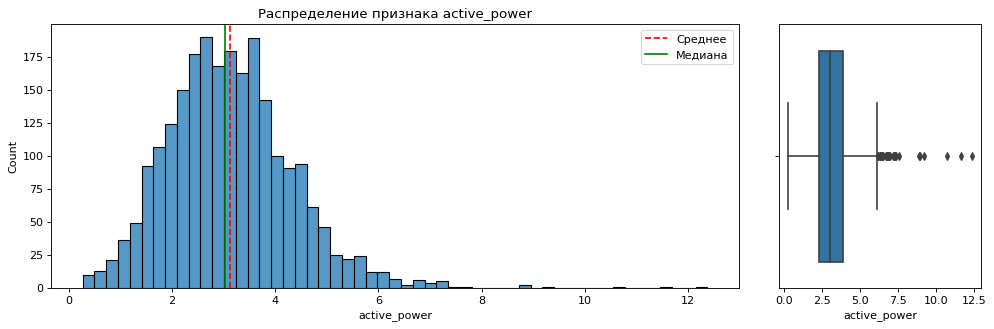

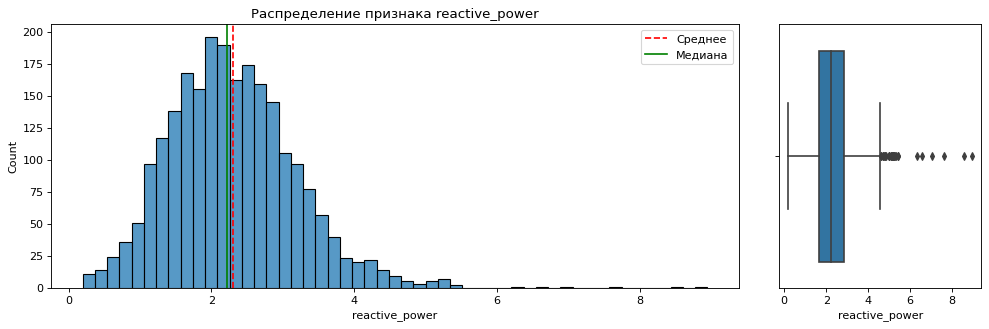

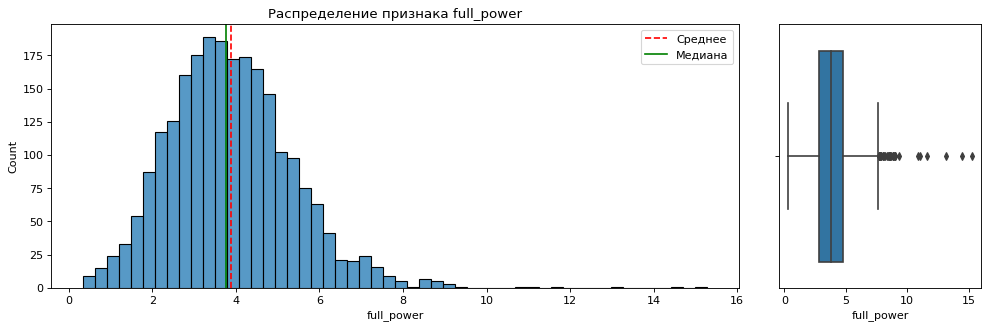

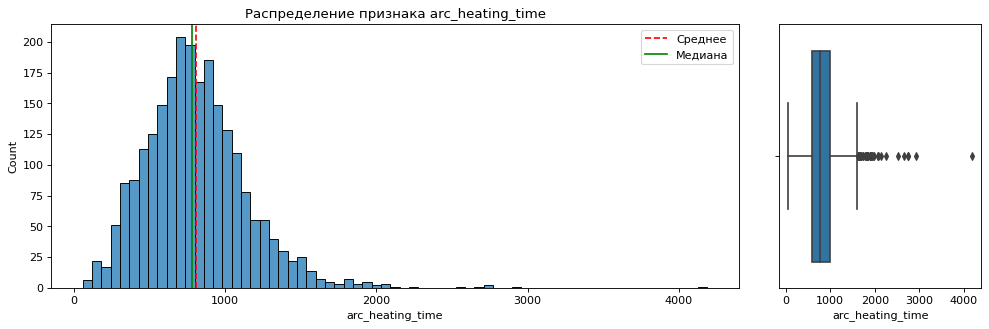

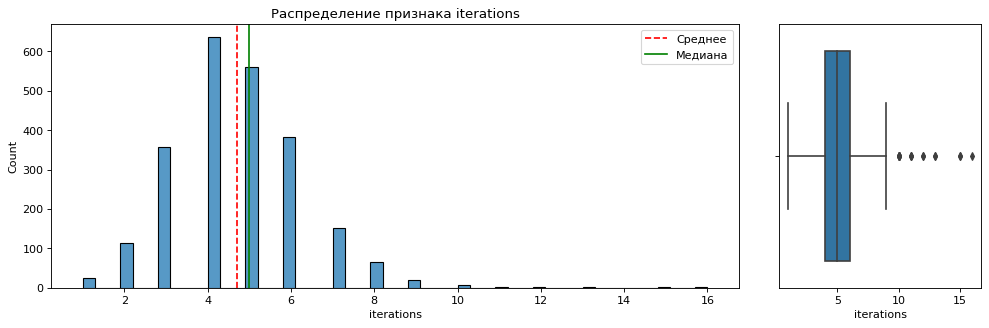

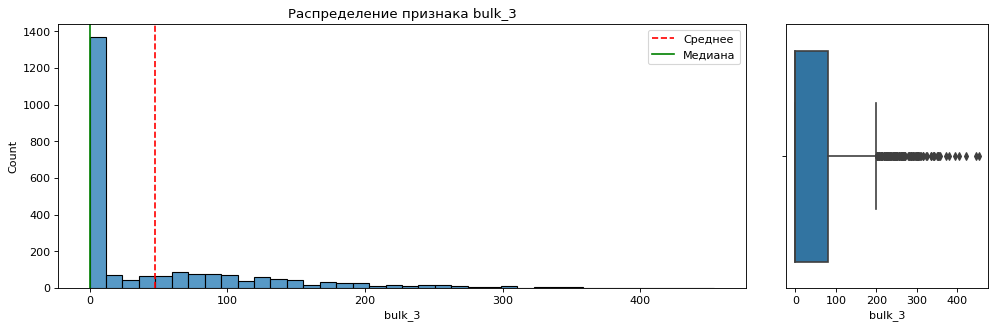

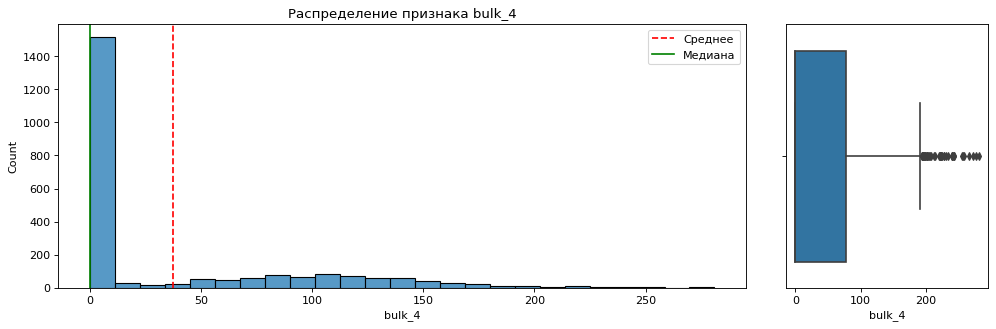

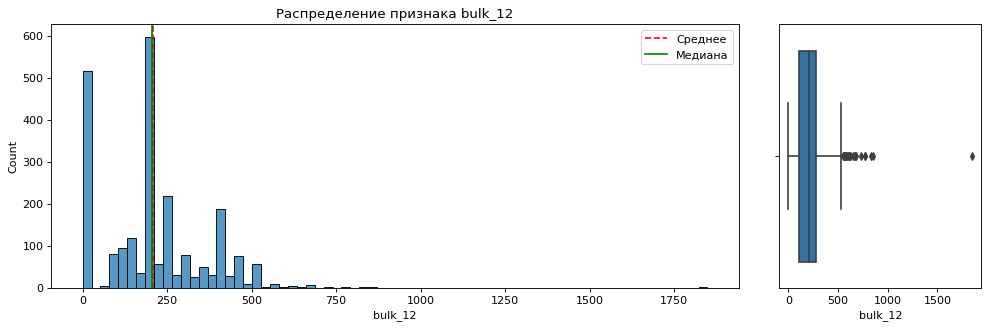

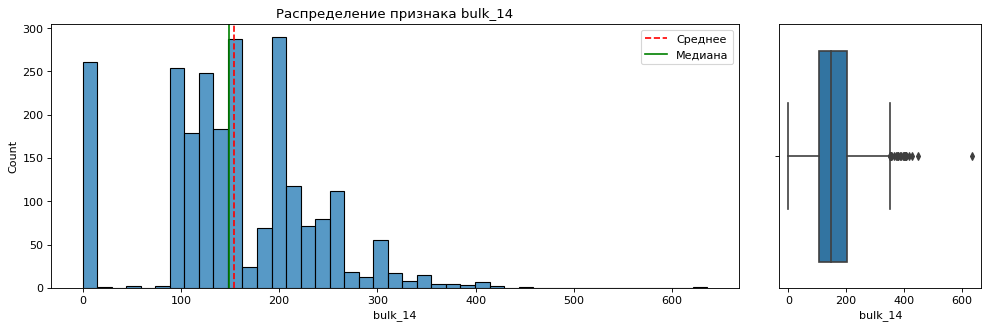

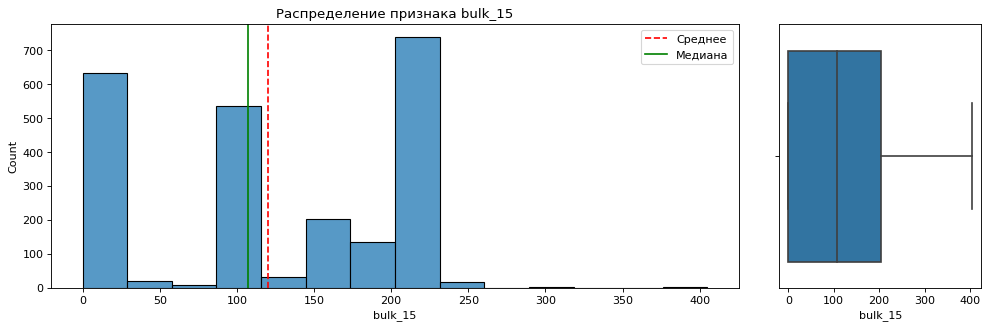

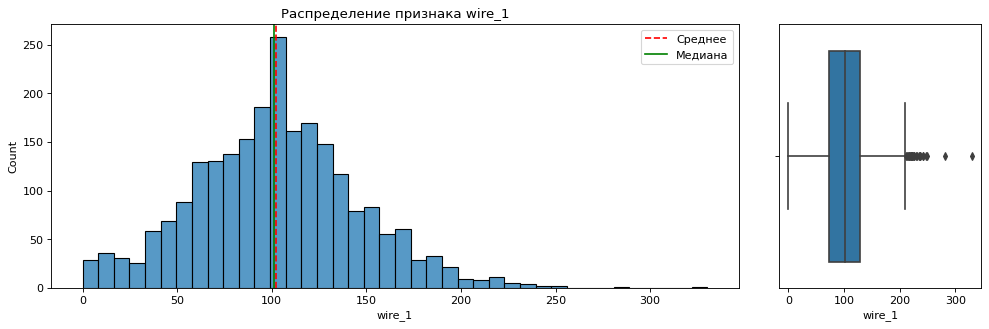

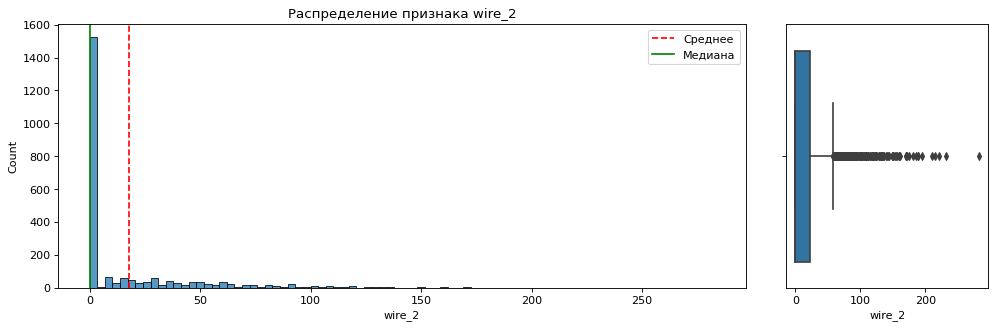

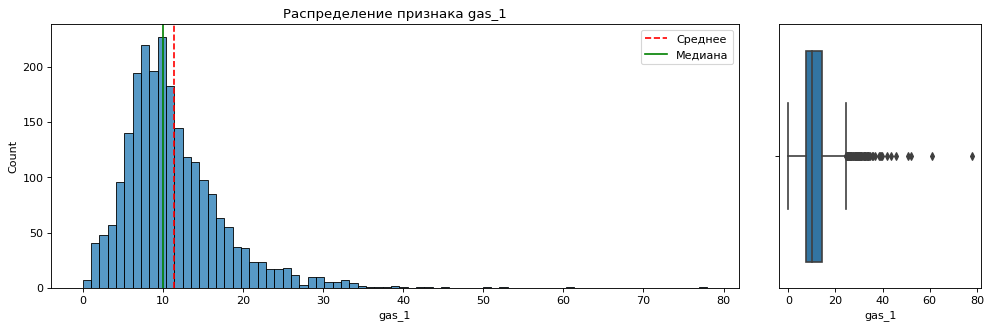

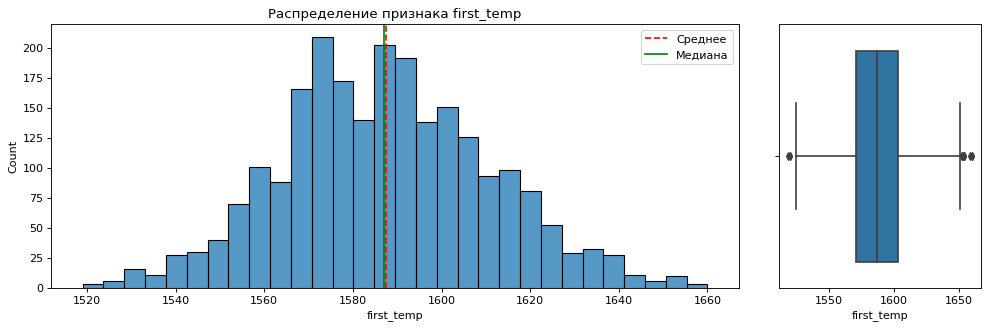

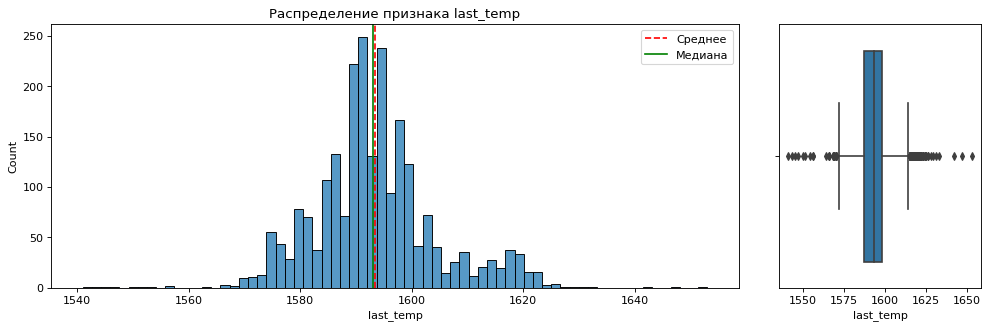

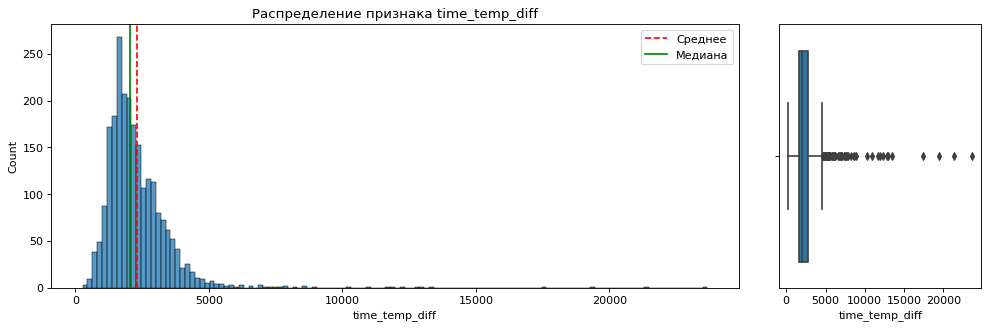

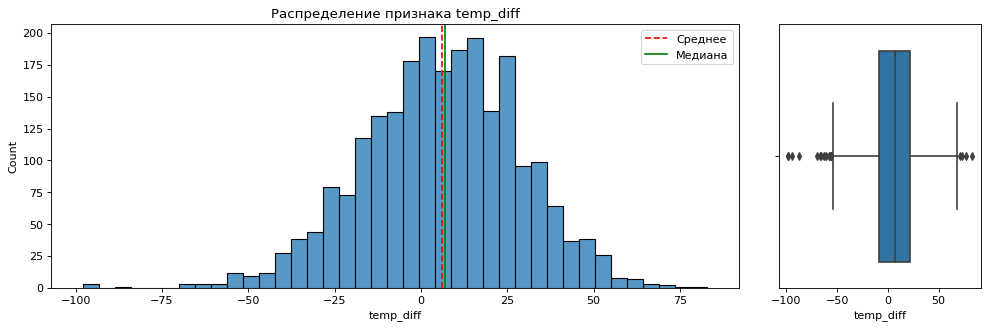

In [188]:
columns = data.columns.to_list()
for i in columns:
    print(i)
    sns_draw(data, i) 

### Визуализация, корреляционный анализ

Построим матрицу корреляции для всех признаков по условию заказчика, используем по умолчанию корреляцию Пирсона:

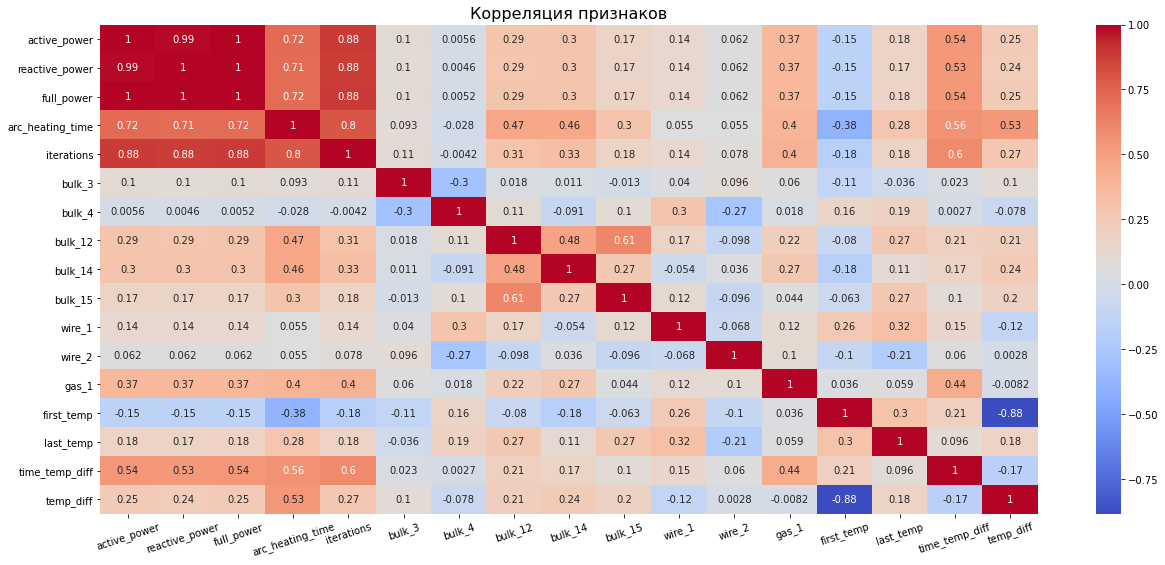

In [189]:
plt.figure(figsize=(21, 9))
fig = sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

Учитывая, что не все признаки распределены нормально, используем phik для построения матрицы корреляции всех признаков

interval columns not set, guessing: ['active_power', 'reactive_power', 'full_power', 'arc_heating_time', 'iterations', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'gas_1', 'first_temp', 'last_temp', 'time_temp_diff', 'temp_diff']


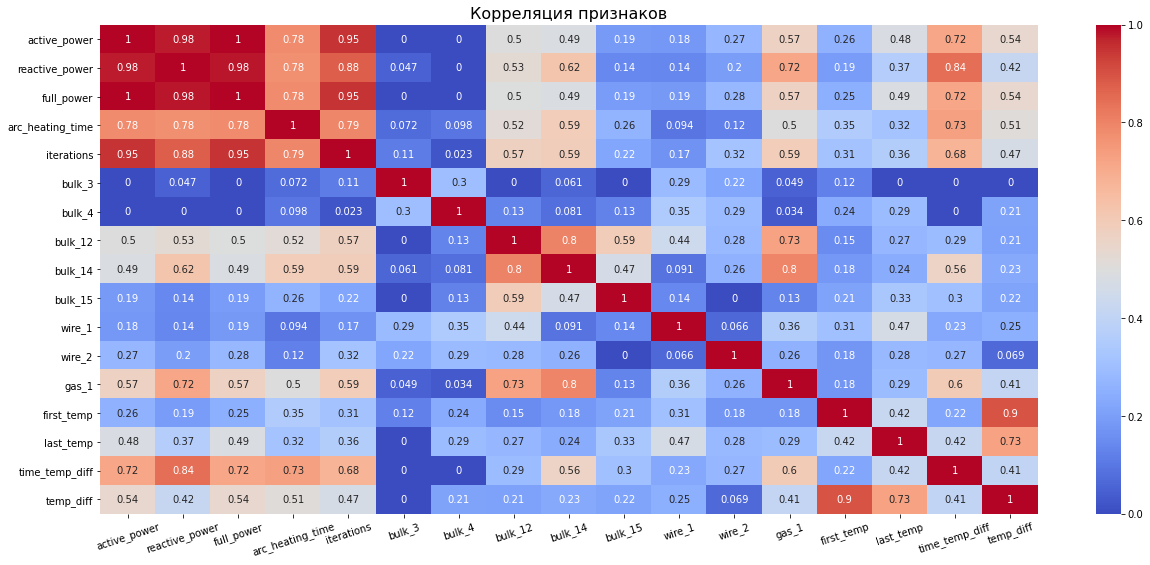

In [190]:
plt.figure(figsize=(21, 9))
fig = sns.heatmap(data.phik_matrix(), cmap='coolwarm', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show() 



В целом, обе матрицы показывают примерно одинаковые результаты: наиболее сильная корреляция наблюдается между признаками `active_power`, `reactive_power`, `full_power`, `arc_heating_time`, `iterations`, а также между `time_temp_diff` и `reactive_power`, `temp_diff` и `first_temp`. 

Что касается целевого признака `last_temp`, то сильнее всего с ним коррелирует признак `temp_diff`, также заметное влияние оказывают признаки `active_power` и `wire_1`. 

Вывод: 
* в объединенной таблице удалены ненужные столбцы
* построены матрицы корреляции Пирсона, phik. 
* проанализированы корреляциии между признаками.

## Подготовка данных

Принято решение не включать в признаки показатель temp_diff, так как он слишком сильно коррелирует с целевым и получается утечка данных (вообще не надо было его добавлять, видимо. С ним, кстати, модель линейной регрессии (изначально брал ее тоже) вообще не ошибалась. В связи с этим, конечно, возникает вопрос о целесообразности всего исследования, ведь если оставить это  признак, то все остальные модели тоже будут работать в 2-3 раза лучше). Также удалим `active_power` и `reactive_power`, т.к. они при наличии `full_power` уже являются избыточными. 

In [191]:
features = data.drop(columns=['last_temp', 'temp_diff', 'active_power', 'reactive_power'])
target = data['last_temp']

In [192]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True
)
print(
    f'Получились выборки в следующих размеров:\n'
    f'{(len(X_train))} — тренировочная;\n'
    f'{(len(X_test))} — тестовая.'
)

Получились выборки в следующих размеров:
1746 — тренировочная;
583 — тестовая.


## Обучение моделей машинного обучения

Попробуем следующие модели:

* «Случайный лес»
* CatBoostRegressor
* LGBMRegressor

**«Случайный лес»**

In [193]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
forest_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
forest_grid.fit(X_train, y_train)
result = abs(forest_grid.best_score_)
print(f'MAE (train): {result:.2f}')

MAE (train): 6.17


**CatBoostRegressor**

In [194]:
model = CatBoostRegressor(verbose=False)
params = {
    'loss_function':['MAE'],
    'depth': [3, 5],  
    'learning_rate': [0.1, 0.2],  
    'n_estimators': [500],  
    'random_state': [RANDOM_STATE],
}
cat_grid = GridSearchCV(model, params, cv=5, verbose=2, scoring='neg_mean_absolute_error', n_jobs=-1)
cat_grid.fit(X_train, y_train)
#train_predictions = cat_grid.predict(X_train)
#result = mean_absolute_error(y_train, train_predictions)
#print(f'MAE (train): {result:.2f}')
abs(cat_grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END depth=3, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.2, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_rate=0.2, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.0s
[CV] END depth=3, learning_rate=0.2, loss_function=MAE, n_estimators=500, random_state=170624; total time=   1.1s
[CV] END depth=3, learning_r

5.949880463490066

In [195]:
cat_grid.best_params_

{'depth': 3,
 'learning_rate': 0.1,
 'loss_function': 'MAE',
 'n_estimators': 500,
 'random_state': 170624}

**LGBMRegressor**

In [196]:
model = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [5, 10],  
    'num_leaves': [5, 10],  
    'learning_rate': [0.05],  
    'random_state': [RANDOM_STATE],
}
lgbm_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', verbose=2)
lgbm_grid.fit(X_train, y_train)
#train_predictions = lgbm_grid.predict(X_train)
#result = mean_absolute_error(y_train, train_predictions)
#print(f'MAE (train): {result:.2f}')
abs(lgbm_grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=5, random_state=170624; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=5, random_state=170624; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=5, random_state=170624; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=5, random_state=170624; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=5, random_state=170624; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=10, random_state=170624; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=10, random_state=170624; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=10, random_state=170624; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=5, metric=mae, num_leaves=10, rand

6.137596110349944

Лучшая модель - CatBoostRegressor

## Выбор лучшей модели

Метрика CatBoostRegressor на тестовых данных:

In [197]:
model = CatBoostRegressor(
    depth=3,
    learning_rate=0.1,
    loss_function='MAE',
    n_estimators=500,
    random_state=170624,
    verbose = False
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
result = mean_absolute_error(y_test, y_pred)
print(f'MAE (test): {result:.2f}')

MAE (test): 6.12


Считаем метрику R2 по желанию Заказчика:

In [198]:
# по простому пути:
r2 = r2_score(y_test, y_pred)
r2

0.45243068174194423

In [199]:
# с визуализацией: создаем объект Pool для тренировочных и тестовых данных
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

In [200]:
# Считаем и печатаем метрику R2
metrics = model.eval_metrics(test_pool, metrics=['R2'], plot=True)
r2 = metrics['R2'][-1]
 
print(f'R-squared (R2): {r2:.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R-squared (R2): 0.4524


показатель 0.45 для метрики R^2 - не очень хороший, т.к. он принимает значения от 0 до 1 и чем он выше, тем лучше. Он дает представление о том, насколько хорошо модель отражает общую дисперсию целевой переменной. Таким образом, можно сделать вывод о том, что в нашем случае модель эффективно объясняет 45% общей дисперсии целевой переменной. 

Проанализируем важность признаков:

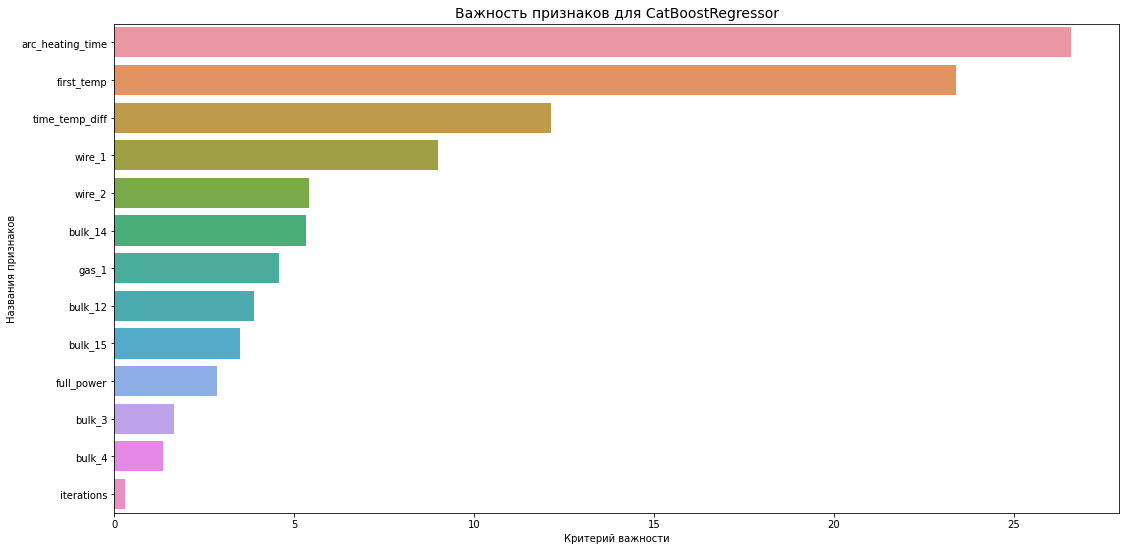

In [201]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

другим способом:

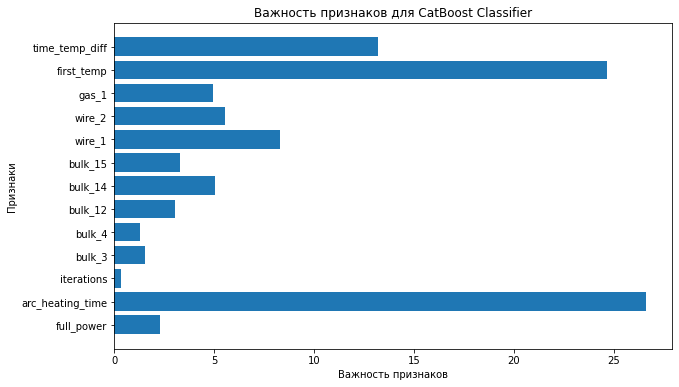

In [202]:
# Получаем feature importance scores
feature_importance = model.get_feature_importance(test_pool)
 
# Get feature names
feature_names = X_test.columns
 
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), 
         feature_importance, 
         tick_label=feature_names)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для CatBoost Classifier')
plt.show()

Добавлю SHAP анализ:

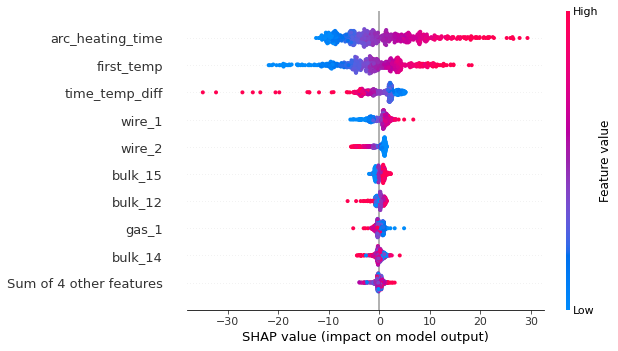

In [203]:
explainer = shap.TreeExplainer(model, X_test)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

Получается, что высокие значения 2-х самых важных признаков - arc_heating_time и first_temp приводят к высоким shap-значениям, а третий по важности признак time_temp_diff оказывает отрицательное влияние (склоняет к минимальным shap  значениям).

Также можно отметить, что по двум верхним признакам, судя по самым толстым линиям по вертикали, модель увереннее всего присваивает SHAP-значения, с учётом закономерностей в данных. 

 
    Исходя из анализа двух графиков важности признаков (разных способов визуализации) можно сделать вывод о том, что самыми важными, имеющими максимальное влияние на целевой, являются признаки `arc_heating_time`, `first_temp`, `time_temp_diff` и `wire_1`.  

уберем iterations, bulk_3, bulk_4 как наименее важные признаки:

In [204]:
X_train_cbr = X_train.drop(columns=['iterations', 'bulk_3', 'bulk_4'])
X_test_cbr = X_test.drop(columns=['iterations', 'bulk_3', 'bulk_4'])

In [205]:
# обучим модель на новых данных без не важных признаков
model_2 = CatBoostRegressor(
    depth=3,
    learning_rate=0.1,
    loss_function='MAE',
    n_estimators=500,
    random_state=170624,
    verbose = False
)

model_2.fit(X_train_cbr, y_train)
y_pred = model_2.predict(X_test_cbr)
result = mean_absolute_error(y_test, y_pred)
print(f'MAE (test): {result:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 (test): {r2:.2f}')

MAE (test): 5.95
R^2 (test): 0.48


Показатель целевой метрики MAE улучшился до отличного диапазона!

Сравним лучшую модель с базовой (Dummy Regressor)

In [206]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_cbr, y_train)
dummy_y_pred = dummy_regr.predict(X_test_cbr)
dummy_score = dummy_regr.score(y_test, dummy_y_pred)
print(f'Метрика МАЕ на тестовой выборке:', mean_absolute_error(y_test, dummy_y_pred))

Метрика МАЕ на тесовой выборке: 8.164665523156089


Наша лучшая модель успешно проходит дамми-тест - с лучшим показателем 5.95. 

## Общий вывод и рекомендации заказчику

**Вывод**

Для обучения были выбраны 3 модели «Случайный лес», CatBoostRegressor, LGBMRegressor. Линейную регрессию не брал, т.к. она подозрительно безошибочно предсказывала результат.
Основные параметры, которые подбирались: глубина «дерева» (depth), скорость обучения (learning_rate), максимальное количество «деревьев» (n_estimators).
Целевая метрика — средняя абсолютная ошибка (MAE) рассчитывается как сумма абсолютных ошибок, делённая на размер выборки.
Лучший показатель получился у модели CatBoostRegressor — 5.95 на тренировочных данных, 6.12 на тестовых и 5.95 после удаления не важных признаков (iterations, bulk_3, bulk_4).

Были также удалены признаки, которые не могут повлиять на обучение, данные о сыпучих и проволочных данных, использованные на крайне малом количестве партий.
Из данных о важности признаков выделяется показатель начальной температуры, что логично говорит о том, что через влияние на начальную температуру можно влиять и на конечную.
По всем признакам названия столбцов были приведены к стандартному виду, обработаны пропуски и выбросы, удалены данные по проблемным партиям, у которых было мало данных по целевому признаку.
Были добавлены дополнительные признаки (не все оказались нужными в итоге).

**Рекомендации Заказчику**

Судя по важности признаков, особое внимание Заказчику рекомендуется обращать на температуры первичных замеров партий, время нагрева, а также объем проволочных материалов, т.к. они являются самыми важными для лучшей обученной модели. В меньшей степени на результат оказывают влияние объемы сыпучих материалов, объемы газа для продувки, а также количество итераций нагрева.

    
Параметры итоговой модели: 
* depth=3,
* learning_rate=0.1,
* loss_function='MAE',
* n_estimators=500,
* random_state=170624